In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mode
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer as Imputer

csv_data=pd.read_csv('2019.csv')
df1=csv_data.dropna(axis=1,how='all')   #删除全是空白值的数据

df2=df1.dropna(thresh=0.7*len(df1),axis=1)   #剔除空白值在70%以上的的列

df3=df2.fillna(df2.mean())    #按照每列的均值填充数据
loan=df3

loan['loan_status']=loan['loan_status'].replace(['Fully Paid','In Grace Period','Late (31-120 days)',
                                                 'Late (16-30 days)','Charged Off','Default','Current'],
                                               ['0','1','1','1','1','1','0'])
loan=loan[loan['loan_status'].isin(['0','1'])]
loan['loan_status']=loan['loan_status'].astype('int')

loan['grade']=loan['grade'].replace(['A','B','C','D','E','F','G'],['5','4','3','2','1','0.5','0'])
loan['emp_length']=loan['emp_length'].replace(['< 1 year','1 year','2 years','3 years','4 years','5 years',
                                               '6 years','7 years','8 years','9 years','10+ years'],
                                              ['0','1','2','3','4','5','6','7','8','9','10'])
loan['home_ownership']=loan['home_ownership'].replace(['RENT','MORTGAGE','OWN','ANY'],['3','2','1','0'])
loan['verification_status']=loan['verification_status'].replace(['Source Verified','Verified','Not Verified'],['3','2','1'])
loan['term']=loan['term'].replace(['36 months','60 months'],['1','2'])
oan=loan.drop(['issue_d'],axis=1)
loan.iloc[0]
loan=loan.drop(['purpose'],axis=1)
loan=loan.drop(['addr_state'],axis=1)
loan=loan.drop(['earliest_cr_line'],axis=1)
loan['revol_util'] = loan['revol_util'].str.strip("%").astype(float)/100
loan['int_rate'] = loan['int_rate'].str.strip("%").astype(float)/100
loan=loan.drop(['application_type'],axis=1)
loan['term']=loan['term'].replace([' 36 months',' 60 months'],['1','2'])

loan['sub_grade']=loan['sub_grade'].replace(['A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','C1','C2','C3','C4','C5',
                                            'D1','D2','D3','D4','D5','E1','E2','E3','E4','E5','F1','F2','F3','F4','F5','G1','G2',
                                            'G3','G4','G5'],['7','6.8','6.6','6.4','6.2','6','5.8','5.6','5.4','5.2','5','4.8','4.6','4.4','4.2',
                                            '4','3.8','3.6','3.4','3.2','3','2.8','2.6','2.4','2.2','2','1.8','1.6','1.4','1.2','1','0.8',
                                            '0.6','0.4','0.2'])
loan=loan.drop(['emp_title'],axis=1)
loan=loan.drop(['grade'],axis=1)
loan=loan.drop(['issue_d'],axis=1)
loan=loan.drop(['title'],axis=1)
loan['pymnt_plan']=loan['pymnt_plan'].replace(['n','y'],['1','2'])
loan=loan.drop(['zip_code'],axis=1)
#loan=loan.drop(['next_pymnt_d'],axis=1)
loan['initial_list_status']=loan['initial_list_status'].replace(['f','w'],['1','2'])
loan=loan.drop(['last_pymnt_d'],axis=1)
loan=loan.drop(['last_credit_pull_d'],axis=1)
loan['hardship_flag']=loan['hardship_flag'].replace(['N','Y'],['1','2'])
loan['disbursement_method']=loan['disbursement_method'].replace(['Cash','DirectPay'],['1','2'])
loan['debt_settlement_flag']=loan['debt_settlement_flag'].replace(['N','Y'],['1','2'])
loan=loan.fillna(loan.mode())    #以中位数数填充

/home/watson/.virtualenvs/notebook/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (13,19,25,32,34,44,46,51,112,121,123,124,125,128,129,130,133,136) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/watson/.virtualenvs/notebook/lib/python3.5/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/watson/.virtualenvs/notebook/lib/python3.5/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

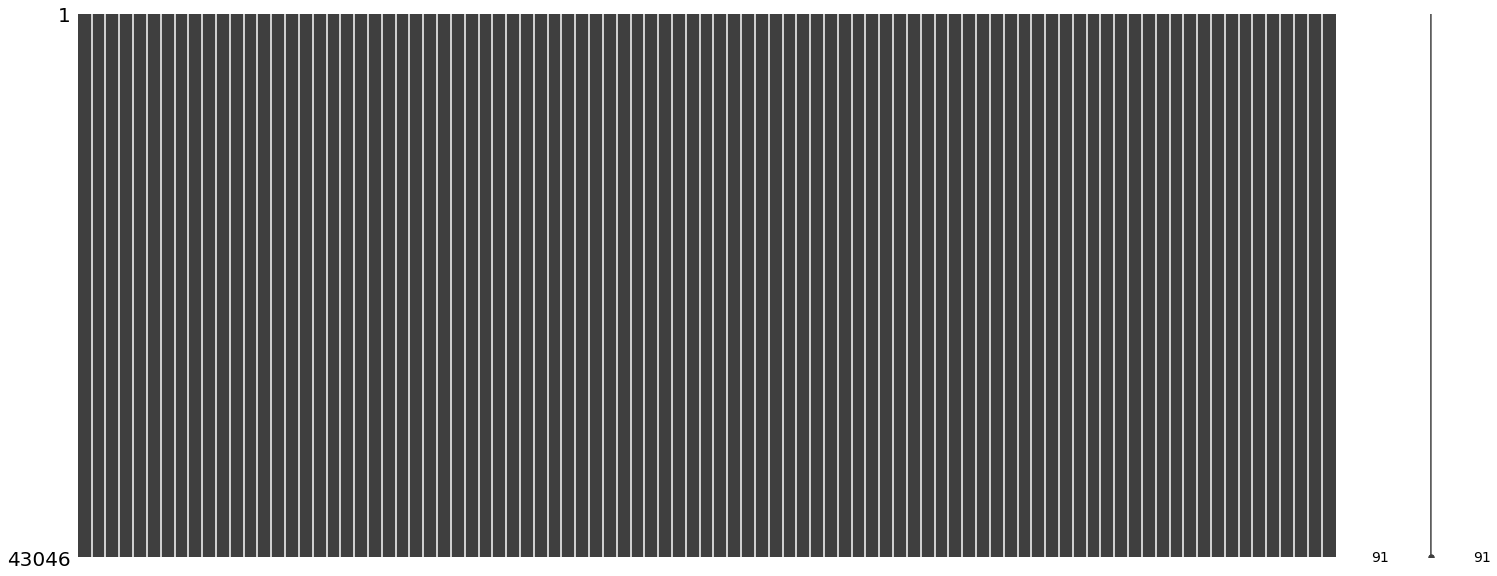

In [2]:
loan=loan.fillna(10)    ##不知道为啥我在用众数填充时，emp_length这一特征总是填不上，所以这个需要你自己先去看看这一列的众数是多少，
                        #然后把10改成你的众数就好

import missingno as msno
msno.matrix(loan) #这是一个查找空白值的程序，如果程序出来的结果都是一条条黑色的条，那就没问题，如果黑色的条纹中，有白色的横杠，那就是说有空白值
                  #这个需要你先安装missingno的程序包，不想用直接把这两行删掉

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
from imblearn.over_sampling import SMOTE

loan=loan.drop(["annual_inc", "delinq_2yrs", "revol_bal", "total_acc", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d", "policy_code"],axis=1)
loan_1=loan.copy()


data_1=loan_1[loan_1['loan_status'] == 1]
data_0=loan_1[loan_1['loan_status'] == 0]

data_1_train,data_1_test=train_test_split(data_1,test_size=.3,random_state=12)
data_0_train,data_0_test=train_test_split(data_0,test_size=.3,random_state=12)
train=pd.concat([data_1_train,data_0_train])
test=pd.concat([data_1_test,data_0_test])

train_X=train.drop(['loan_status'],axis=1)
train_y=train['loan_status']
test_X=test.drop(['loan_status'],axis=1)
test_y=test['loan_status']

#resampled_X,resampled_y=SMOTE(random_state=12).fit_sample(train_X,train_y)
rf=RandomForestClassifier(n_estimators=500,max_depth=10,random_state=1).fit(train_X,train_y)
importance=pd.DataFrame({'features':train_X.columns.values,'importance':rf.feature_importances_})
importance.sort_values(by='importance',ascending=False).style.bar()
loan=loan.drop(importance[importance['importance'] < 0.0015]['features'].values,axis=1)#此处的0.0015随你，改成多少都没问题，不过这
                                                                                       #里尽可能小吧，毕竟还要在这里面做相关性，太大了特征太少

In [4]:
importance.sort_values(by='importance',ascending=False).style.bar()  #这是重要性的图

,features,importance
21,total_rec_prncp,0.178503
24,recoveries,0.171299
20,total_pymnt_inv,0.0833064
19,total_pymnt,0.0819544
23,total_rec_late_fee,0.0583859
17,out_prncp,0.0471445
18,out_prncp_inv,0.045001
5,installment,0.0346015
2,funded_amnt_inv,0.0256494
1,funded_amnt,0.0246536


['dti', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'tot_coll_amt', 'mths_since_rcnt_il', 'total_cu_tl', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'total_bc_limit', 'total_il_high_credit_limit']
['term', 'sub_grade', 'verification_status', 'pymnt_plan', 'hardship_flag', 'debt_settlement_flag']


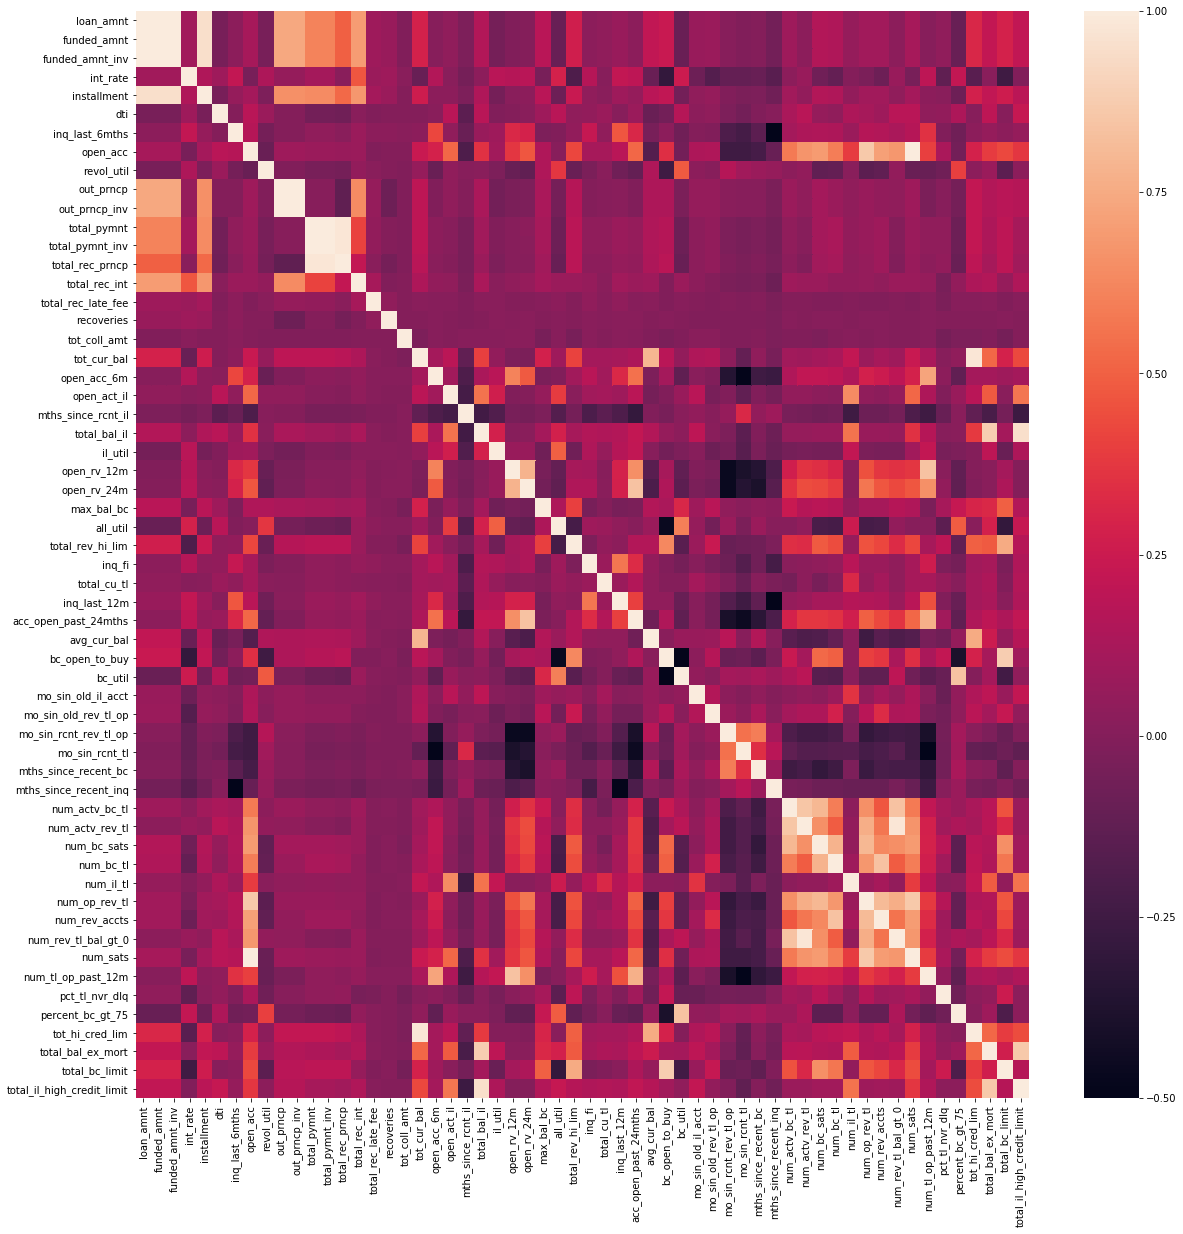

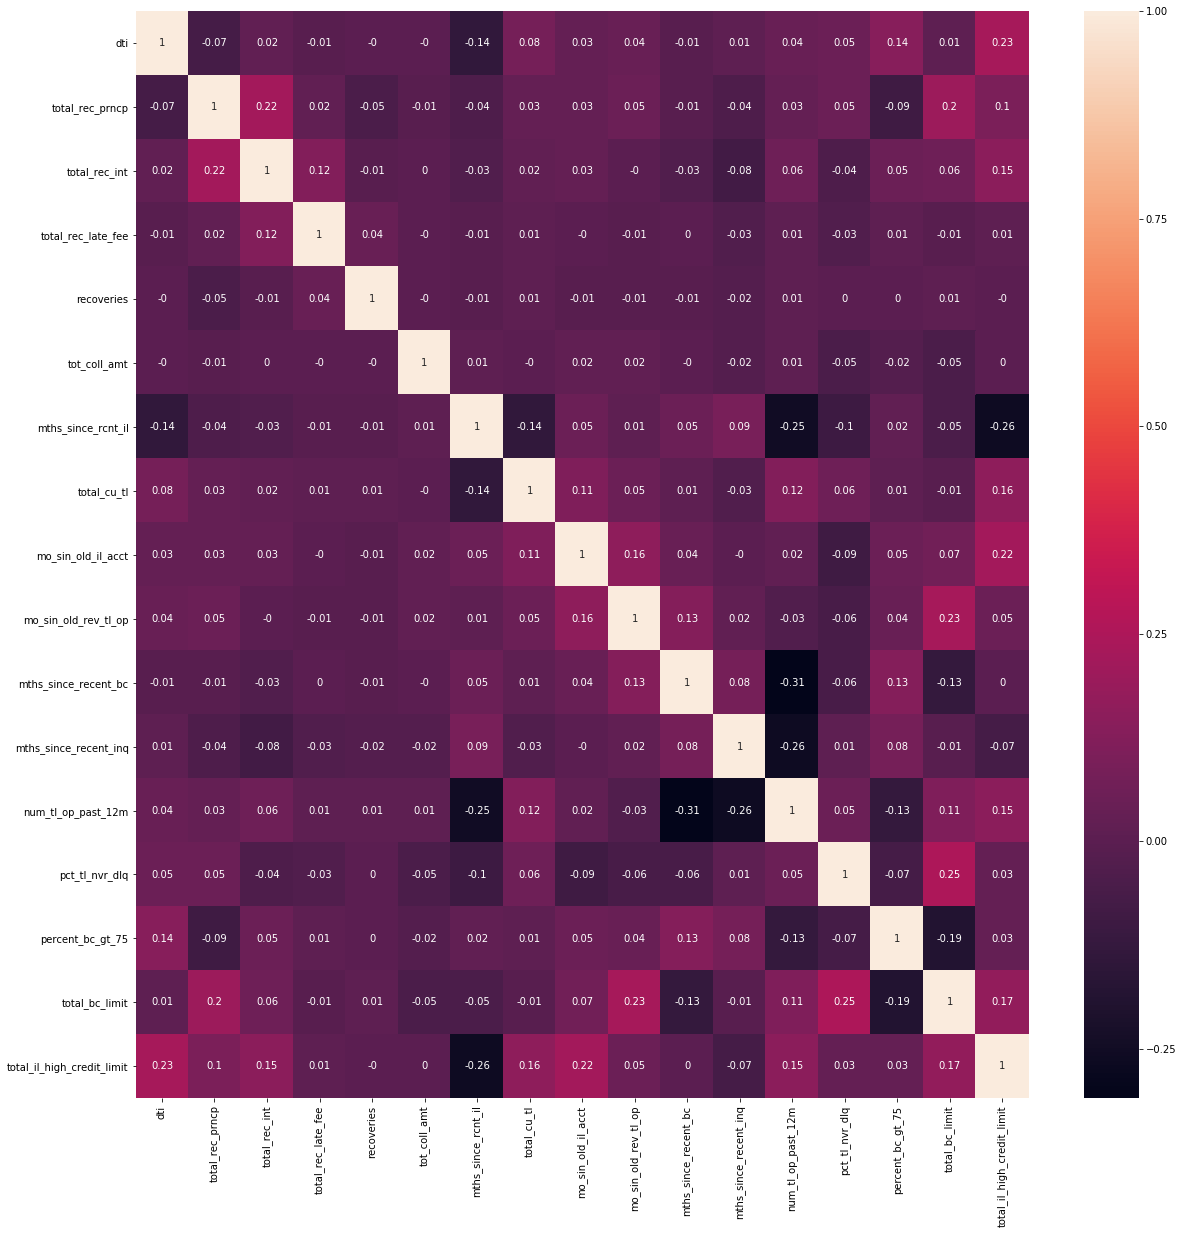

In [5]:
num_features=[]
obj_features=[]
for i in loan.columns.values:
    if loan[i].dtype == 'object':
        obj_features.append(i)
    else:
        num_features.append(i)
num_features.remove('loan_status')

fig,ax=plt.subplots(figsize=(20,20))
sns.heatmap(loan[num_features].corr().round(2))


cor=(np.abs(loan[num_features].corr()) < 0.4)  #这里的0.4是相关性阈值，随你选择，数值越大特征越多
l=[]
for i in range(len(num_features)):
    s=(cor.iloc[i+1:,i].sum() == (len(num_features)-i-1))
    l.append(s)
    
num_feats=[]
for i in range(len(num_features)):
    if l[i]:
        num_feats.append(num_features[i])
        
fig,ax=plt.subplots(figsize=(20,20))
sns.heatmap(loan[num_feats].corr().round(2),annot=True)
print(num_feats)   #这是做完相关性后的数据型特征
print(obj_features)#这是文本型特征

In [23]:
def Chi2(df, total_col, bad_col, overallRate):
    '''
     #此函数计算卡方值
     :df dataFrame
     :total_col 每个值得总数量
     :bad_col 每个值的坏数据数量
     :overallRate 坏数据的占比
     : return 卡方值
    '''
    df2 = df.copy()
    df2['expected'] = df[total_col].apply(lambda x: x * overallRate)
    combined = zip(df2['expected'], df2[bad_col])
    chi = [(i[0] - i[1]) ** 2 / i[0] for i in combined]
    chi2 = sum(chi)
    return chi2


# 基于卡方阈值卡方分箱，有个缺点，不好控制分箱个数。
def ChiMerge_MinChisq(df, col, target, confidenceVal=3.841):
    '''
    #此函数是以卡方阈值作为终止条件进行分箱
    : df dataFrame
    : col 被分箱的特征
    : target 目标值,是0,1格式
    : confidenceVal  阈值，自由度为1， 自信度为0.95时，卡方阈值为3.841
    : return 分箱。
    这里有个问题，卡方分箱对分箱的数量没有限制，这样子会导致最后分箱的结果是分箱太细。
    '''
    # 对待分箱特征值进行去重
    colLevels = set(df[col])

    # count是求得数据条数
    total = df.groupby([col])[target].count()

    total = pd.DataFrame({'total': total})

    # sum是求得特征值的和
    # 注意这里的target必须是0,1。要不然这样求bad的数据条数，就没有意义，并且bad是1，good是0。
    bad = df.groupby([col])[target].sum()
    bad = pd.DataFrame({'bad': bad})
    # 对数据进行合并，求出col，每个值的出现次数（total，bad）
    regroup = total.merge(bad, left_index=True, right_index=True, how='left')
    regroup.reset_index(level=0, inplace=True)

    # 求出整的数据条数
    N = sum(regroup['total'])
    # 求出黑名单的数据条数
    B = sum(regroup['bad'])
    overallRate = B * 1.0 / N

    # 对待分箱的特征值进行排序
    colLevels = sorted(list(colLevels))
    groupIntervals = [[i] for i in colLevels]

    groupNum = len(groupIntervals)
    while (1):
        if len(groupIntervals) == 1:
            break
        chisqList = []
        for interval in groupIntervals:
            df2 = regroup.loc[regroup[col].isin(interval)]
            chisq = Chi2(df2, 'total', 'bad', overallRate)
            chisqList.append(chisq)

        min_position = chisqList.index(min(chisqList))

        if min(chisqList) >= confidenceVal:
            break

        if min_position == 0:
            combinedPosition = 1
        elif min_position == groupNum - 1:
            combinedPosition = min_position - 1
        else:
            if chisqList[min_position - 1] <= chisqList[min_position + 1]:
                combinedPosition = min_position - 1
            else:
                combinedPosition = min_position + 1
        groupIntervals[min_position] = groupIntervals[min_position] + groupIntervals[combinedPosition]
        groupIntervals.remove(groupIntervals[combinedPosition])
        groupNum = len(groupIntervals)
    return groupIntervals


# 最大分箱数分箱
def ChiMerge_MaxInterval_Original(df, col, target, max_interval=5):
    '''
    : df dataframe
    : col 要被分项的特征
    ： target 目标值 0,1 值
    : max_interval 最大箱数
    ：return 箱体
    '''
    colLevels = set(df[col])
    colLevels = sorted(list(colLevels))
    N_distinct = len(colLevels)
    if N_distinct <= max_interval:
        print
        "the row is cann't be less than interval numbers"
        return colLevels[:-1]
    else:
        total = df.groupby([col])[target].count()
        total = pd.DataFrame({'total': total})
        bad = df.groupby([col])[target].sum()
        bad = pd.DataFrame({'bad': bad})
        regroup = total.merge(bad, left_index=True, right_index=True, how='left')
        regroup.reset_index(level=0, inplace=True)
        N = sum(regroup['total'])
        B = sum(regroup['bad'])
        overallRate = B * 1.0 / N
        groupIntervals = [[i] for i in colLevels]
        groupNum = len(groupIntervals)
        while (len(groupIntervals) > max_interval):
            chisqList = []
            for interval in groupIntervals:
                df2 = regroup.loc[regroup[col].isin(interval)]
                chisq = Chi2(df2, 'total', 'bad', overallRate)
                chisqList.append(chisq)
            min_position = chisqList.index(min(chisqList))
            if min_position == 0:
                combinedPosition = 1
            elif min_position == groupNum - 1:
                combinedPosition = min_position - 1
            else:
                if chisqList[min_position - 1] <= chisqList[min_position + 1]:
                    combinedPosition = min_position - 1
                else:
                    combinedPosition = min_position + 1
            # 合并箱体
            groupIntervals[min_position] = groupIntervals[min_position] + groupIntervals[combinedPosition]
            groupIntervals.remove(groupIntervals[combinedPosition])
            groupNum = len(groupIntervals)
        groupIntervals = [sorted(i) for i in groupIntervals]
        print
        groupIntervals
        cutOffPoints = [i[-1] for i in groupIntervals[:-1]]
        return cutOffPoints


# 计算WOE和IV值
def CalcWOE(df, col, target):
    '''
    : df dataframe
    : col 注意这列已经分过箱了，现在计算每箱的WOE和总的IV
    ：target 目标列 0-1值
    ：return 返回每箱的WOE和总的IV
    '''
    total = df.groupby([col])[target].count()
    total = pd.DataFrame({'total': total})
    bad = df.groupby([col])[target].sum()
    bad = pd.DataFrame({'bad': bad})
    regroup = total.merge(bad, left_index=True, right_index=True, how='left')
    regroup.reset_index(level=0, inplace=True)
    N = sum(regroup['total'])
    B = sum(regroup['bad'])
    regroup['good'] = regroup['total'] - regroup['bad']
    G = N - B
    regroup['bad_pcnt'] = regroup['bad'].map(lambda x: x * 1.0 / B)
    regroup['good_pcnt'] = regroup['good'].map(lambda x: x * 1.0 / G)
    regroup['WOE'] = regroup.apply(lambda x: np.log(x.good_pcnt * 1.0 / x.bad_pcnt), axis=1)
    WOE_dict = regroup[[col, 'WOE']].set_index(col).to_dict(orient='index')
    IV = regroup.apply(lambda x: (x.good_pcnt - x.bad_pcnt) * np.log(x.good_pcnt * 1.0 / x.bad_pcnt), axis=1)
    IV_SUM = sum(IV)
    return {'WOE': WOE_dict, 'IV_sum': IV_SUM, 'IV': IV}


# 分箱以后检查每箱的bad_rate的单调性，如果不满足，那么继续进行相邻的两项合并，直到bad_rate单调为止
def BadRateMonotone(df, sortByVar, target):
    # df[sortByVar]这列已经经过分箱
    df2 = df.sort_values(by=[sortByVar])
    total = df2.groupby([sortByVar])[target].count()
    total = pd.DataFrame({'total': total})
    bad = df2.groupby([sortByVar])[target].sum()
    bad = pd.DataFrame({'bad': bad})
    regroup = total.merge(bad, left_index=True, right_index=True, how='left')
    regroup.reset_index(level=0, inplace=True)
    combined = zip(regroup['total'], regroup['bad'])
    badRate = [x[1] * 1.0 / x[0] for x in combined]
    badRateMonotone = [badRate[i] < badRate[i + 1] for i in range(len(badRate) - 1)]
    Monotone = len(set(badRateMonotone))
    if Monotone == 1:
        return True
    else:
        return False


# 检查最大箱，如果最大箱里面数据数量占总数据的90%以上，那么弃用这个变量
def MaximumBinPcnt(df, col):
    N = df.shape[0]
    total = df.groupby([col])[col].count()
    pcnt = total * 1.0 / N
    return max(pcnt)


# 对于类别型数据，以bad_rate代替原有值，转化成连续变量再进行分箱计算。比如我们这里的户籍地代码，就是这种数据格式
# 当然如果类别较少时，原则上不需要分箱
def BadRateEncoding(df, col, target):
    '''
    : df DataFrame
    : col 需要编码成bad rate的特征列
    ：target值，0-1值
    ： return: the assigned bad rate
    '''
    total = df.groupby([col])[target].count()
    total = pd.DataFrame({'total': total})
    bad = df.groupby([col])[target].sum()
    bad = pd.DataFrame({'bad': bad})
    regroup = total.merge(bad, left_index=True, right_index=True, how='left')
    regroup.reset_index(level=0, inplace=True)
    regroup['bad_rate'] = regroup.apply(lambda x: x.bad * 1.0 / x.total, axis=1)
    br_dict = regroup[[col, 'bad_rate']].set_index([col]).to_dict(orient='index')
    badRateEnconding = df[col].map(lambda x: br_dict[x]['bad_rate'])
    return {'encoding': badRateEnconding, 'br_rate': br_dict}

In [25]:
# purpose=BadRateEncoding(loan,'purpose','loan_status')
# loan['purpose']=purpose['encoding']

num_features=[]
obj_features=[]
for i in loan.columns.values:
    if loan[i].dtype == 'object':
        obj_features.append(i)
    else:
        num_features.append(i)
num_features.remove('loan_status')

train,test=train_test_split(loan,test_size=.3,random_state=12)

cuts=[]
for i in num_features:
    cut=ChiMerge_MaxInterval_Original(train,i,'loan_status',max_interval=5)
    cut=[float('-inf')]+cut
    cut.append(float('inf'))
    cuts.append(cut)
    train[i]=pd.cut(train[i],cut)

columns=train.columns.values.tolist()
columns.remove('loan_status')
WOEs={}
IVs=[]
for i in columns:
    woe,iv=chisqbin.CalcWOE(train,i,'loan_status')
    WOEs[i]=woe
    IVs.append(iv)

IV=pd.DataFrame({'feature':columns,'IV':IVs})
IV.sort_values(by='IV',ascending=False).style.bar()

/home/watson/.virtualenvs/notebook/lib/python3.5/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/watson/.virtualenvs/notebook/lib/python3.5/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/watson/.virtualenvs/notebook/lib/python3.5/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

KeyboardInterrupt: 

In [ ]:
# 选取出IV值大于0.02的变量，用它们对应的WOE对数据进行替换。
features=IV.loc[IV['IV'] > 0.02,'feature'].values
features=features.tolist()
features.append('loan_status')

for i in range(len(columns)):
    col=columns[i]
    train[col]=train[col].replace(WOEs[col])

for i in range(len(num_features)):
    col=num_features[i]
    test[col]=pd.cut(test[col],cuts[i])

for i in range(len(columns)):
    col=columns[i]
    test[col]=test[col].replace(WOEs[col])  

In [ ]:
# 分割数据
train=train[features]
test=test[features]

train_X=train.drop('loan_status',axis=1)
train_y=train['loan_status']
test_X=test.drop('loan_status',axis=1)
test_y=test['loan_status']

In [ ]:
import tensorflow as tf 
from  tensorflow.examples.tutorials.mnist  import  input_data
import numpy as np 

def get_next_batch(i_count):
    return train_X[i_count*100:(i_count + 1)*100], train_y[i_count*100:(i_count + 1)*100]

num_classes = 10  # 输出大小
input_size = 784  # 输入大小
hidden_units_size = 30  # 隐藏层节点数量
batch_size = 100
training_iterations = 10000

X = tf.placeholder(tf.float32, shape = [None, input_size])
Y = tf.placeholder(tf.float32, shape = [None, num_classes])

W1 = tf.Variable(tf.random_normal ([input_size, hidden_units_size], stddev = 0.1))
B1 = tf.Variable(tf.constant (0.1), [hidden_units_size])
W2 = tf.Variable(tf.random_normal ([hidden_units_size, num_classes], stddev = 0.1))
B2 = tf.Variable(tf.constant (0.1), [num_classes])

hidden_opt = tf.matmul(X, W1) + B1  # 输入层到隐藏层正向传播
hidden_opt = tf.nn.relu(hidden_opt)  # 激活函数，用于计算节点输出值
final_opt = tf.matmul(hidden_opt, W2) + B2  # 隐藏层到输出层正向传播


# 对输出层计算交叉熵损失
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=final_opt))
# 梯度下降算法，这里使用了反向传播算法用于修改权重，减小损失
opt = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
# 初始化变量
init = tf.global_variables_initializer()
# 计算准确率
correct_prediction =tf.equal (tf.argmax (Y, 1), tf.argmax(final_opt, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

sess = tf.Session ()
sess.run (init)
for i in range (training_iterations) :
    batch_input, batch_labels = get_next_batch(i)
    # 训练
    training_loss = sess.run ([opt, loss], feed_dict = {X: batch_input, Y: batch_labels})
    if i % 1000 == 0 :
        train_accuracy = accuracy.eval (session = sess, feed_dict = {X: batch_input,Y: batch_labels})
        print ("step : %d, training accuracy = %g " % (i, train_accuracy))